# Modelling

In this notebook we'll carry on from the EDA, and begin modelling. Before that, we'll deal with the outliers identified in the EDA, namely the sleep duration, heart rate and blood pressure level fields.

## Dealing With Outliers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
import seaborn as sns

In [4]:
sns.set()
path = "../../Oxygen_only/Oxygen-Light.ttf"
fontManager.addfont(path)

prop = FontProperties(fname=path)
sns.set(font=prop.get_name())

Firstly, we'll start by loading in the data, and selecting only the fields that were identified during the EDA:
- sleep_duration
- heart_rate
- blood_pressure_level
- sleep_disorder (target variable)

In [8]:
sleep_data = pd.read_csv("./processed_data.csv")
sleep_data = sleep_data[['sleep_duration', 'heart_rate', 'bp_level', 'sleep_disorder']]
sleep_data.head()

,sleep_duration,heart_rate,bp_level,sleep_disorder
0,6.1,77,Stage 1 High,None
1,6.2,75,Stage 1 High,None
2,6.2,75,Stage 1 High,None
3,5.9,85,Stage 2 High,Sleep Apnea
4,5.9,85,Stage 2 High,Sleep Apnea


To identify outliers, we'll plot boxplots of the numerical fields by sleep disorder.

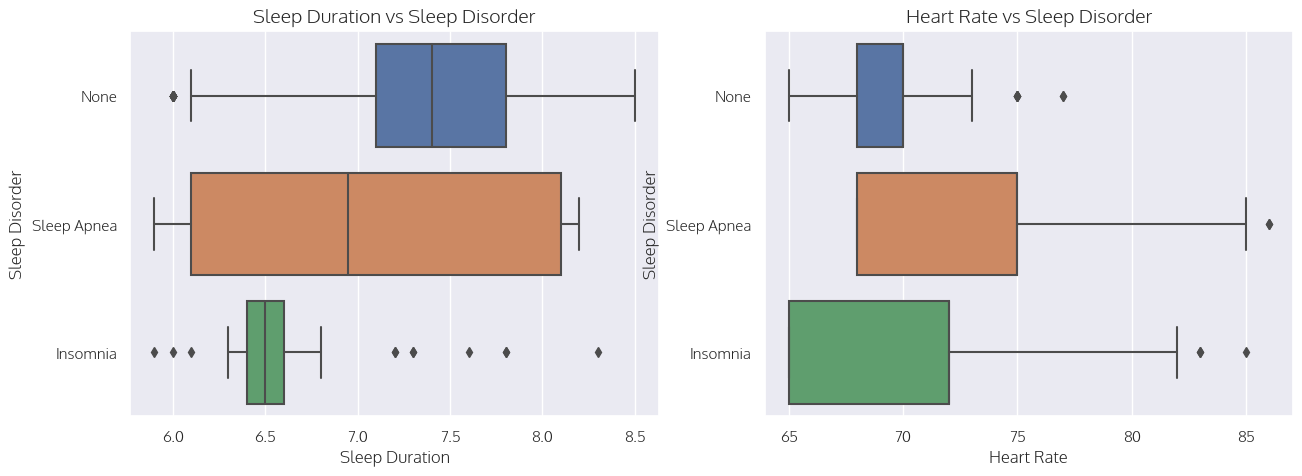

In [13]:
#2 axes side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#plot boxplot between sleep duration and sleep disorder
#then plot boxplot between heart rate and sleep disorder

sns.boxplot(y='sleep_disorder', x='sleep_duration', data=sleep_data, ax=axes[0])
axes[0].set_title("Sleep Duration vs Sleep Disorder", fontsize=14)
axes[0].set_xlabel("Sleep Duration", fontsize=12)
axes[0].set_ylabel("Sleep Disorder", fontsize=12)

sns.boxplot(y='sleep_disorder', x='heart_rate', data=sleep_data, ax=axes[1])
axes[1].set_title("Heart Rate vs Sleep Disorder", fontsize=14)
axes[1].set_xlabel("Heart Rate", fontsize=12)
axes[1].set_ylabel("Sleep Disorder", fontsize=12)

plt.show()

As can be seen above, there are quite a lot of outliers in the sleep duration field, in particular, for those samples with 'Insomnia'. One solution to handle these is to clip the outliers to the values of the upper and lower whiskers. In general this can also be done for the heart rate field, which seems to have 5 outliers in total for all categories of the sleep disorder field.

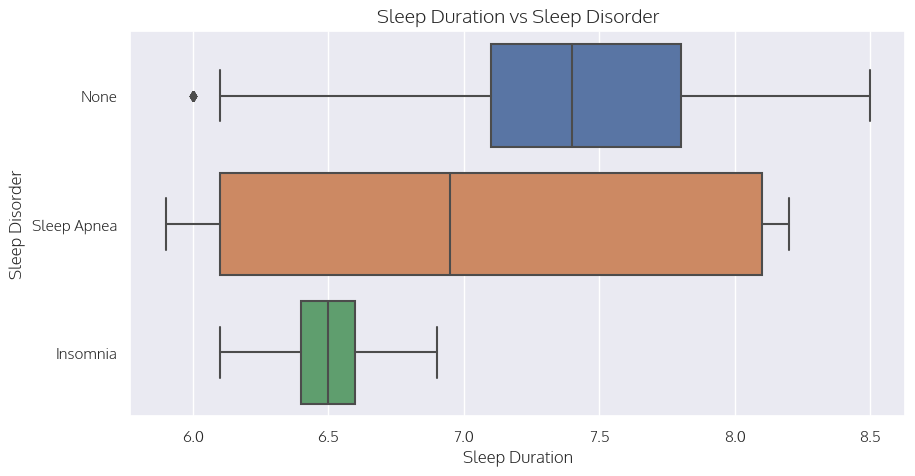

In [29]:
insomnia_samples = sleep_data[sleep_data['sleep_disorder'] == 'Insomnia']
lower_limit, upper_limit = np.percentile(insomnia_samples['sleep_duration'], [25, 75])
iqr = upper_limit - lower_limit
lower_bound = lower_limit - (1.5 * iqr)
upper_bound = upper_limit + (1.5 * iqr)
sleep_data_sleep_duration_clip = sleep_data.copy()
#clip sleep duration for samples with insomnia to these values using loc
insomnia_sleep_durations = sleep_data_sleep_duration_clip.loc[sleep_data_sleep_duration_clip['sleep_disorder'] == 'Insomnia', 'sleep_duration']
insomnia_sleep_durations = insomnia_sleep_durations.clip(lower_bound, upper_bound)
sleep_data_sleep_duration_clip.loc[sleep_data_sleep_duration_clip['sleep_disorder'] == 'Insomnia', 'sleep_duration'] = insomnia_sleep_durations

#plot boxplot between sleep duration and sleep disorder only
plt.figure(figsize=(10, 5))
sns.boxplot(y='sleep_disorder', x='sleep_duration', data=sleep_data_sleep_duration_clip)
plt.title("Sleep Duration vs Sleep Disorder", fontsize=14)
plt.xlabel("Sleep Duration", fontsize=12)
plt.ylabel("Sleep Disorder", fontsize=12)
plt.show()


The None sleep disorder also has one outlier, however, it's quite close to the lower whisker and so we'll leave it as is.

In [32]:
#function that calculates then removes outliers for a given sleep disorder, and a given numeric feature, similar to the above, also df gets passed in
def clip_outliers(df, sleep_disorder, feature):
    samples = df[df['sleep_disorder'] == sleep_disorder]
    lower_limit, upper_limit = np.percentile(samples[feature], [25, 75])
    iqr = upper_limit - lower_limit
    lower_bound = lower_limit - (1.5 * iqr)
    upper_bound = upper_limit + (1.5 * iqr)
    df_clip = df.copy()
    feature_values = df_clip.loc[df_clip['sleep_disorder'] == sleep_disorder, feature]
    feature_values = feature_values.clip(lower_bound, upper_bound)
    df_clip.loc[df_clip['sleep_disorder'] == sleep_disorder, feature] = feature_values
    return df_clip

#clip outliers for ['None', 'Insomnia', 'Sleep Apnea'] for heart duration, get composed dataframe
sleep_data_to_clip = sleep_data_sleep_duration_clip.copy()
for sleep_disorder in ['None', 'Insomnia', 'Sleep Apnea']:
    sleep_data_to_clip = clip_outliers(sleep_data_to_clip, sleep_disorder, 'heart_rate')

sleep_data_clipped = sleep_data_to_clip.copy()

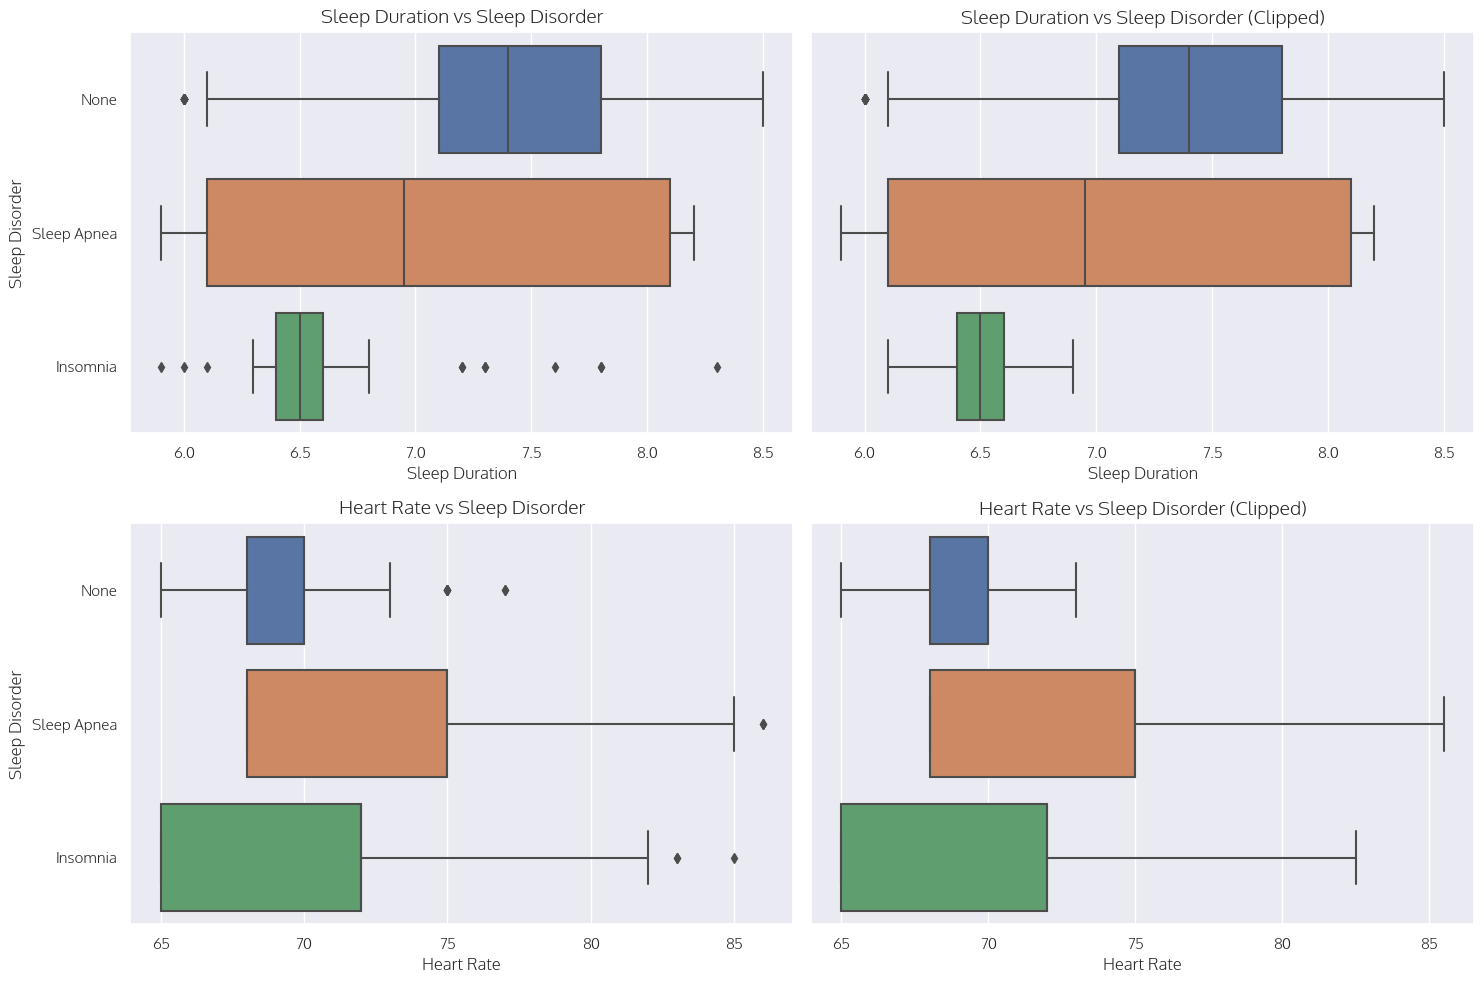

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)

#on first column plot boxplot for unclipped data using sleep_data
#then using sleep_data_clipped plot box plot for corresponding feature
#share y axis for both columns
sns.boxplot(y='sleep_disorder', x='sleep_duration', data=sleep_data, ax=axes[0, 0])
axes[0, 0].set_title("Sleep Duration vs Sleep Disorder", fontsize=14)
axes[0, 0].set_xlabel("Sleep Duration", fontsize=12)
axes[0, 0].set_ylabel("Sleep Disorder", fontsize=12)

sns.boxplot(y='sleep_disorder', x='sleep_duration', data=sleep_data_clipped, ax=axes[0, 1])
axes[0, 1].set_title("Sleep Duration vs Sleep Disorder (Clipped)", fontsize=14)
axes[0, 1].set_xlabel("Sleep Duration", fontsize=12)
axes[0, 1].set_ylabel("", fontsize=12)

sns.boxplot(y='sleep_disorder', x='heart_rate', data=sleep_data, ax=axes[1, 0])
axes[1, 0].set_title("Heart Rate vs Sleep Disorder", fontsize=14)
axes[1, 0].set_xlabel("Heart Rate", fontsize=12)
axes[1, 0].set_ylabel("Sleep Disorder", fontsize=12)

sns.boxplot(y='sleep_disorder', x='heart_rate', data=sleep_data_clipped, ax=axes[1, 1])
axes[1, 1].set_title("Heart Rate vs Sleep Disorder (Clipped)", fontsize=14)
axes[1, 1].set_xlabel("Heart Rate", fontsize=12)
axes[1, 1].set_ylabel("", fontsize=12)
plt.tight_layout()
plt.show()


As the plot shows, outliers have been removed!

Next we explore the counts of blood pressure levels.

In [39]:
print(sleep_data_clipped['bp_level'].value_counts())

Stage 1 High    227
Stage 2 High    100
Normal           41
Elevated          1
Name: bp_level, dtype: int64


While most of the samples have a blood pressure condition, it's evident that there's only one sample with an elevated blood pressure level. We could deal with this by removing the sample, or bunching it with the Stage 1 category, however, this will mean the model will not be able to make sense of presence of elevated blood pressure levels. Therefore, the best course of option is to drop this column entirely.

In [40]:
sleep_data_v3 = sleep_data_clipped.copy()
#drop bp_level
sleep_data_v3.drop('bp_level', axis=1, inplace=True)

Currently, we've selected only 2 features for the modelling stage, both are numeric, and therefore it could prove to be helpful to visualize them using a scatter plot.

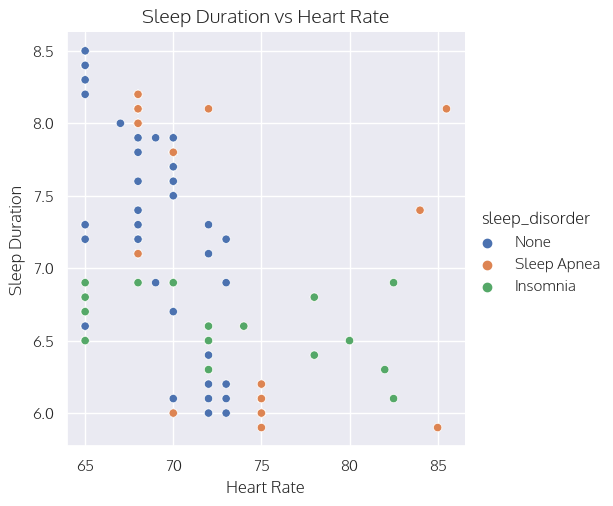

                sleep_duration  heart_rate
sleep_duration        1.000000   -0.499602
heart_rate           -0.499602    1.000000


In [44]:
sns.relplot(
    x='heart_rate',
    y='sleep_duration',
    data=sleep_data_v3,
    hue='sleep_disorder',
)
plt.title("Sleep Duration vs Heart Rate", fontsize=14)
plt.xlabel("Heart Rate", fontsize=12)
plt.ylabel("Sleep Duration", fontsize=12)
plt.show()

#caclulate correlation between sleep duration and heart rate
print(sleep_data_v3[['sleep_duration', 'heart_rate']].corr())

The plot shows the following:
- There's a negative correlation between the heart rate and sleep duration (as expected)
- There doesn't appear to be a way in which the sleep disorders can be separated through the scatter plot, however, this is mostly due to the fact that a lot of heart rate and sleep duration values appear more often, such as 75s, 80s and so on.
- One thing we could do is to carry out PCA on these features, and then plot the first 2 principal components to see:
    - If the sleep disorders can be separated.
    - If the explained variance of just one feature is good enough.

### Feature Engineering

In this section we'll explore the possibility of applying PCA to the 2 selected features - sleep duration, and heart rate.

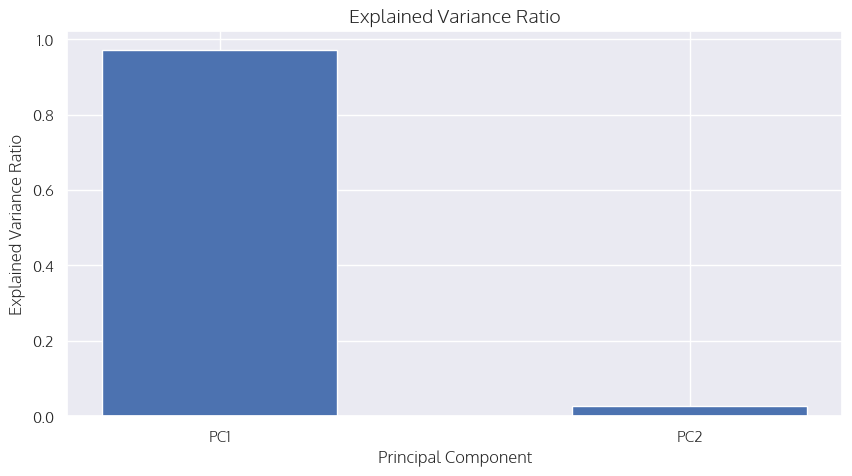

[0.97173834 0.02826166]


In [51]:
from sklearn.decomposition import PCA

pca = PCA()

transformed_data = pca.fit_transform(sleep_data_v3[['sleep_duration', 'heart_rate']])
#bar plot of explained variance ratio
plt.figure(figsize=(10, 5))

plt.bar(
    x=['PC1', 'PC2'],
    height=pca.explained_variance_ratio_,
    width=0.5
)

plt.title("Explained Variance Ratio", fontsize=14)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)

plt.show()

#print explained variance ratio
print(pca.explained_variance_ratio_)

In [55]:
np.var(transformed_data[:, 0])

15.782886292995357

Performing PCA has shown that the intrinsic dimensionality of the data may be 1, with the first principal component explaining 97% of the data.

### Modelling

After having conducted the feature preprocessing and selection step, we can now move onto the modelling. This is a multi-class classification problem, thus models that can naturally handle such tasks will be selected. Ofcourse selecting the most performant model will provide the best results, but it's often better to start with simpler more explainable models, thus for this modelling task we choose the K-Nearst Neighbors, and the Decision Tree Classifier. Both these models can inherently handle multi-class classification tasks, and are also explainable.

Evident from the exploratory analysis, the data is imbalanced, and to deal with this, we can use stratified sampling when splitting the data into training and testing sets. This will ensure that the training and testing sets have the same distribution of the target variable. 
- The test size will be 30% of the data.
- Furthermore, PCA will be performed on the training set, and the same transformation will be applied to the testing set. This is to ensure that the testing set is not used in any way to influence the training set.
- For the KNN model, when training with both features, the data will be scaled using the StandardScaler.

From the dimensionality reduction experiment in the previous stage, it was shown that just the first principal component is capable of explaining almost all of the variance of the data, therefore, we'll use this as the input to the models, and later compare by training the models on both the raw features as well. The advantage of using the raw data, is that the model will be more interpretable, and we'll be able to see which features are most important in the decision making process.

#### Training on the first principal component

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler

#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    sleep_data_v3[['sleep_duration', 'heart_rate']],
    sleep_data_v3['sleep_disorder'],
    test_size=0.3,
    stratify=sleep_data_v3['sleep_disorder'],
    random_state=42
)

pca = PCA(n_components=1)

X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

#fit decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_transformed, y_train)

#predict on test data
y_pred = dt.predict(X_test_transformed)

#print classification report
print(classification_report(y_test, y_pred))
print('\n')
#print confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Insomnia       0.92      0.96      0.94        23
        None       1.00      0.97      0.98        65
 Sleep Apnea       0.92      0.96      0.94        23

    accuracy                           0.96       111
   macro avg       0.94      0.96      0.95       111
weighted avg       0.97      0.96      0.96       111



[[22  0  1]
 [ 1 63  1]
 [ 1  0 22]]


In [77]:
#do same process for KNN
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_transformed, y_train)
y_pred = knn.predict(X_test_transformed)

print(classification_report(y_test, y_pred))
print('\n')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Insomnia       0.95      0.91      0.93        23
        None       0.97      0.97      0.97        65
 Sleep Apnea       0.88      0.91      0.89        23

    accuracy                           0.95       111
   macro avg       0.93      0.93      0.93       111
weighted avg       0.95      0.95      0.95       111



[[21  0  2]
 [ 1 63  1]
 [ 0  2 21]]


The results above show that the both models are performing exceptionally well:
- Both models perform nearly equally well on the Insomnia, and No Sleep Disorer categories.
- Decision Tree performs far better on Sleep Apnea
- Just the first principal component is a great predictor on its own
- The results need to be taken with a grain of salt, as the data is imbalanced

#### Training on the raw features

To later plot the decision tree, we'll limit the maximum depth to 3, this will ensure that the tree is not too large, and is easier to interpret. Furthermore, there will be more samples in each leaf node, and thus the model will be less prone to overfitting.

In [91]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    sleep_data_v3[['sleep_duration', 'heart_rate']],
    sleep_data_v3['sleep_disorder'],
    test_size=0.3,
    stratify=sleep_data_v3['sleep_disorder'],
    random_state=42
)

#fit decision tree classifier
dt = DecisionTreeClassifier(random_state=42, max_depth=3)

dt.fit(X_train, y_train)

#predict on test data
y_pred = dt.predict(X_test)

#print classification report
print(classification_report(y_test, y_pred))
print('\n')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Insomnia       0.92      0.96      0.94        23
        None       1.00      0.97      0.98        65
 Sleep Apnea       0.92      0.96      0.94        23

    accuracy                           0.96       111
   macro avg       0.94      0.96      0.95       111
weighted avg       0.97      0.96      0.96       111



[[22  0  1]
 [ 1 63  1]
 [ 1  0 22]]


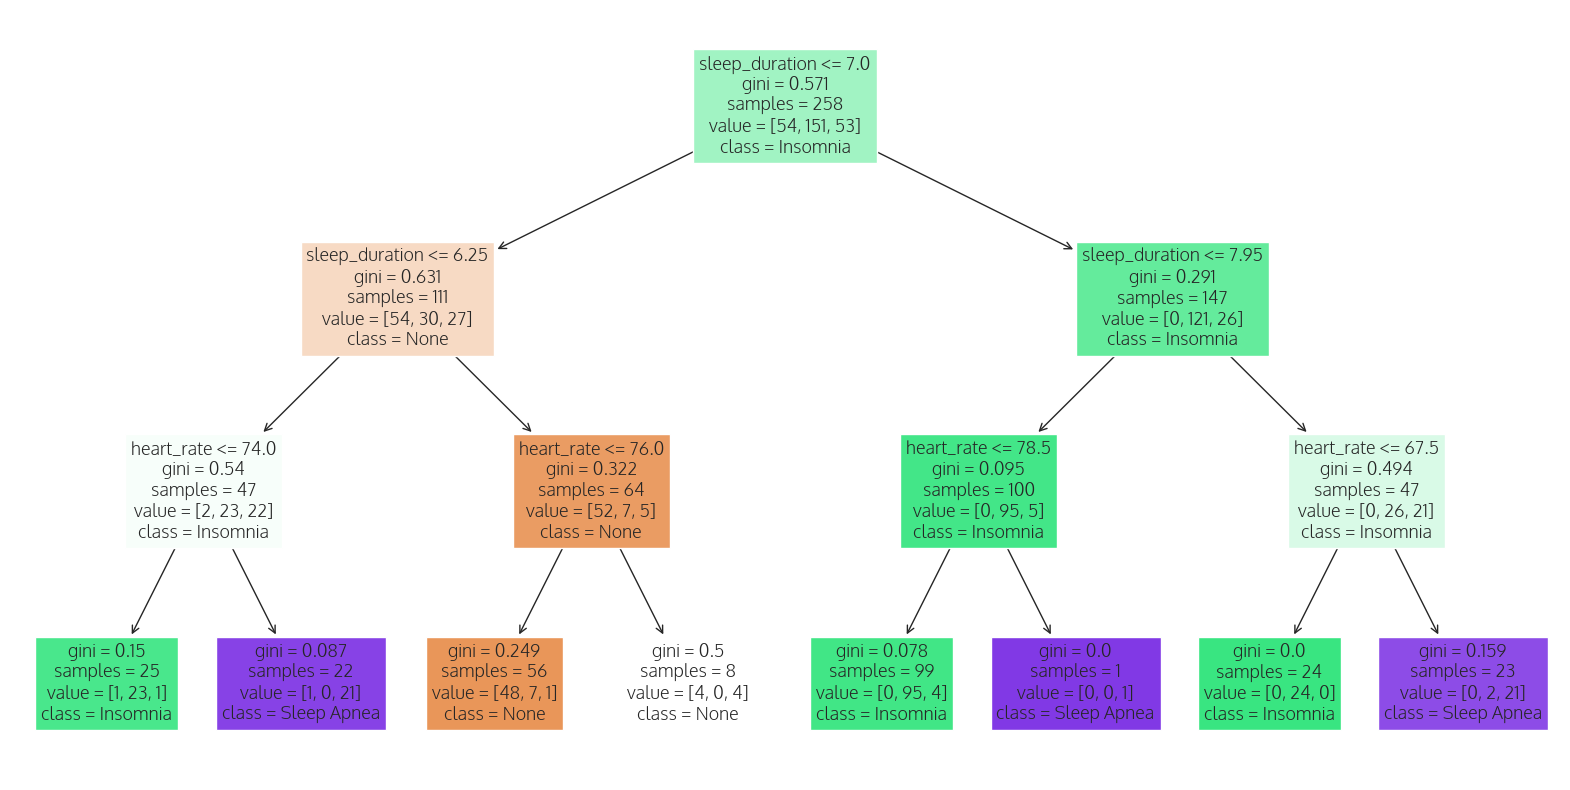

In [84]:
#plot decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=['sleep_duration', 'heart_rate'], class_names=['None', 'Insomnia', 'Sleep Apnea'])
plt.show()

Visualizing the decision tree shows the following:
- That sleep duration is the ideal feature to split on, and is the root variable.
- Shows that heart rate is being used when predicting the Sleep Apnea category. This aligns with the analysis.
- Interestingly enough, only one leaf is being used to classify into the No Sleep Disorder category.

In [79]:
#do same process for KNN
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
print('\n')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Insomnia       0.96      0.96      0.96        23
        None       0.97      0.97      0.97        65
 Sleep Apnea       0.91      0.91      0.91        23

    accuracy                           0.95       111
   macro avg       0.95      0.95      0.95       111
weighted avg       0.95      0.95      0.95       111



[[22  0  1]
 [ 1 63  1]
 [ 0  2 21]]


Training on the raw features has led to some interesting insights:
- The KNN model is performing better than when trained on the first principal component
    - In particular, it's performing much better on the Sleep Apnea class
    - Doing better than the Decision Tree model on the Insomnia class

## Conclusion

As the results show above, the exploratory analysis and modelling has led to selection of features that are near-perfect predictors, highlighting the fact, that no matter the complexity of the modelling technique, exploratory analysis builds a vital foundation for the experiment to come.